In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2 as cv
from skimage.feature import hog
from skimage.transform import resize
from skimage.io import imread, imshow, imsave

In [ ]:
import zipfile
import glob

file = glob.glob('./clothing-dataset-small-master.zip')

with zipfile.ZipFile(file[0], 'r') as zip_ref:
    zip_ref.extractall('data/')

In [ ]:
### BEST ###
### RUN THIS ONE###
# batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras import backend as K

# def f1_micro(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2 / ((1/precision) + (1/recall))
tf.config.run_functions_eagerly(True)
from sklearn.metrics import accuracy_score, f1_score, make_scorer
def f1_micro(y_true, y_pred):    
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)    
    return f1_score(y_true, y_pred, average='micro')


np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(5,5), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(5,5), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=[f1_micro])
history = model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=32)
# access training history
print(history.history.keys())

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/30
96/96 [==============================] - 98s 1s/step - loss: 2.1902 - f1_micro: 0.2270 - val_loss: 2.1503 - val_f1_micro: 0.2420
Epoch 2/30
96/96 [==============================] - 95s 988ms/step - loss: 2.0961 - f1_micro: 0.2822 - val_loss: 1.9221 - val_f1_micro: 0.3314
Epoch 3/30
96/96 [==============================] - 97s 1s/step - loss: 1.7894 - f1_micro: 0.3891 - val_loss: 1.6557 - val_f1_micro: 0.4367
Epoch 4/30
96/96 [==============================] - 95s 992ms/step - loss: 1.6215 - f1_micro: 0.4415 - val_loss: 1.4885 - val_f1_micro: 0.5049
Epoch 5/30
96/96 [==============================] - 97s 1s/step - loss: 1.4903 - f1_micro: 0.5032 - val_loss: 1.3421 - val_f1_micro: 0.5506
Epoch 6/30
96/96 [==============================] - 100s 1s/step - loss: 1.3815 - f1_micro: 0.5363 - val_loss: 1.2068 - val_f1_micro: 0.5875
Epoch 7/30
96/96 [========

In [ ]:
# Evaluate the model on the test set
print("batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)")
test_acc = model.evaluate(test_generator) 
print("Test f1_micro:", test_acc[1])

batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)
12/12 [==============================] - 3s 265ms/step - loss: 0.7121 - f1_micro: 0.7542
Test f1_micro: 0.7541666626930237


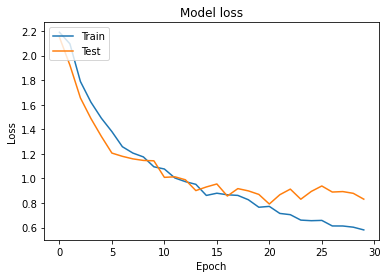

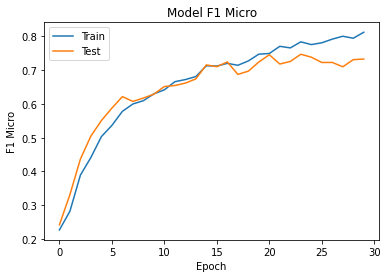

In [ ]:
# plot training history, batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
### VARIOUS EXPERIMENTS ###
### varying: batch_size, epochs, kernel_size, pool_size

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc',f1_micro,precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=10, batch_size=32)
# access training history
print(history.history.keys())

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/10
96/96 [==============================] - 48s 492ms/step - loss: 2.1954 - acc: 0.2301 - f1_micro: 0.0029 - precision_m: 0.0123 - recall_m: 0.0016 - val_loss: 2.1377 - val_acc: 0.2375 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
96/96 [==============================] - 47s 490ms/step - loss: 2.0129 - acc: 0.2953 - f1_micro: 0.0909 - precision_m: 0.3927 - recall_m: 0.0535 - val_loss: 1.7647 - val_acc: 0.3871 - val_f1_micro: 0.2418 - val_precision_m: 0.8377 - val_recall_m: 0.1437
Epoch 3/10
96/96 [==============================] - 45s 467ms/step - loss: 1.7686 - acc: 0.4035 - f1_micro: 0.2880 - precision_m: 0.7993 - recall_m: 0.1809 - val_loss: 1.5746 - val_acc: 0.4809 - val_f1_micro: 0.3759 - val_precision_m: 0.7570 - val_recall_m: 0.2532
Epoch 4/10
96/96 [==============================] - 45s 469ms/step

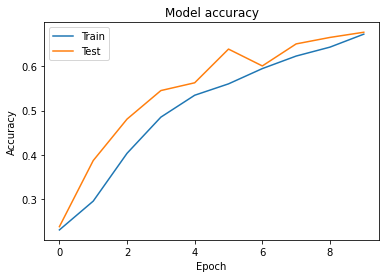

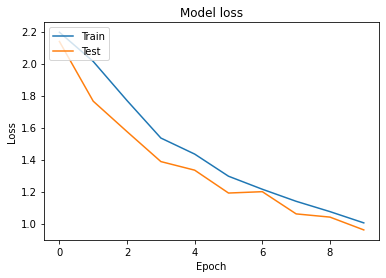

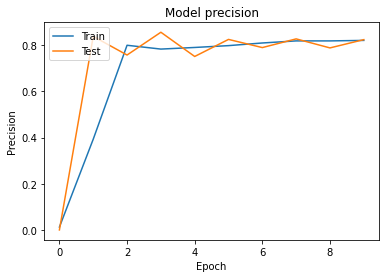

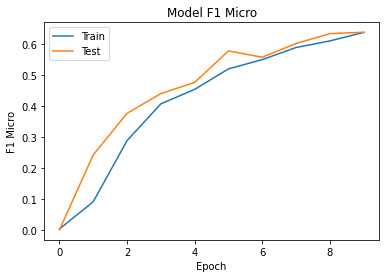

In [ ]:
# plot training history, epochs=10, kernel_size=(3,3), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc',f1_micro,precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=20, batch_size=32)
# access training history
print(history.history.keys())

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/20
96/96 [==============================] - 48s 486ms/step - loss: 2.1809 - acc: 0.2399 - f1_micro: 0.0104 - precision_m: 0.0793 - recall_m: 0.0062 - val_loss: 2.1227 - val_acc: 0.2375 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
96/96 [==============================] - 46s 473ms/step - loss: 1.9929 - acc: 0.3302 - f1_micro: 0.1002 - precision_m: 0.4367 - recall_m: 0.0582 - val_loss: 1.7715 - val_acc: 0.3871 - val_f1_micro: 0.2973 - val_precision_m: 0.6988 - val_recall_m: 0.1906
Epoch 3/20
96/96 [==============================] - 52s 540ms/step - loss: 1.6990 - acc: 0.4286 - f1_micro: 0.3283 - precision_m: 0.8161 - recall_m: 0.2115 - val_loss: 1.6072 - val_acc: 0.4692 - val_f1_micro: 0.3240 - val_precision_m: 0.9100 - val_recall_m: 0.2035
Epoch 4/20
96/96 [==============================] - 49s 505ms/step

ValueError: too many values to unpack (expected 2)

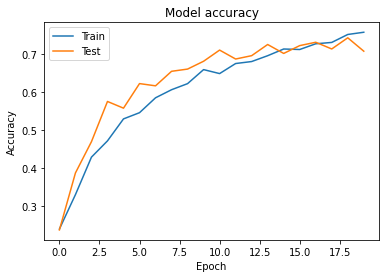

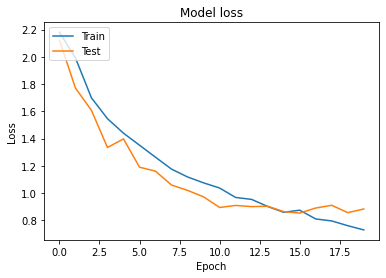

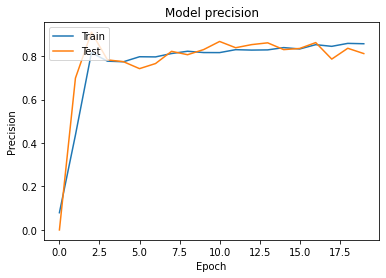

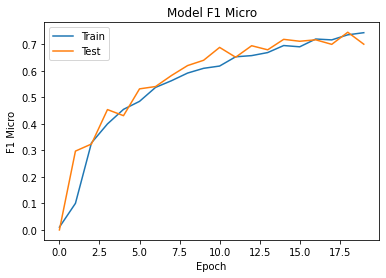

In [ ]:
# plot training history, epochs=20, kernel_size=(3,3), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# batch size 8
# epochs 30
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 / ((1/precision) + (1/recall))


np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc',f1_micro,precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=8)
# access training history
print(history.history.keys())

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/30
96/96 [==============================] - 51s 526ms/step - loss: 2.1871 - acc: 0.2399 - f1_micro: 0.0107 - precision_m: 0.0502 - recall_m: 0.0066 - val_loss: 2.0391 - val_acc: 0.3138 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
96/96 [==============================] - 48s 494ms/step - loss: 1.9246 - acc: 0.3328 - f1_micro: 0.1601 - precision_m: 0.7359 - recall_m: 0.0931 - val_loss: 1.7540 - val_acc: 0.3871 - val_f1_micro: 0.2217 - val_precision_m: 0.8768 - val_recall_m: 0.1308
Epoch 3/30
96/96 [==============================] - 47s 490ms/step - loss: 1.6718 - acc: 0.4241 - f1_micro: 0.3170 - precision_m: 0.7874 - recall_m: 0.2042 - val_loss: 1.4845 - val_acc: 0.4927 - val_f1_micro: 0.4303 - val_precision_m: 0.7148 - val_recall_m: 0.3129
Epoch 4/30
96/96 [==============================] - 46s 481ms/step

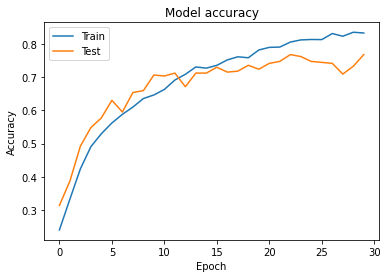

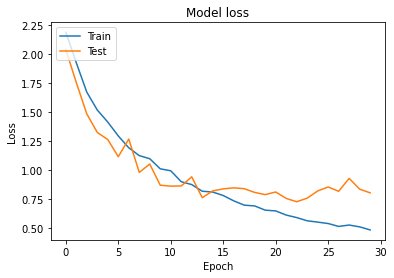

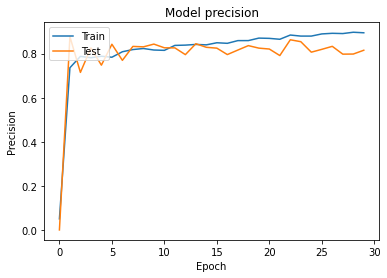

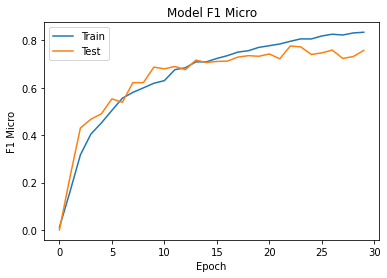

In [ ]:
# plot training history, batch_size=8, epochs=30, kernel_size=(3,3), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set 
test_acc = model.evaluate(test_generator) 
print("Test accuracy:", test_acc[1])
print("Test f1_micro:", test_acc[2])

12/12 [==============================] - 1s 115ms/step - loss: 0.9002 - acc: 0.7392 - f1_micro: 0.7299 - precision_m: 0.7682 - recall_m: 0.6969
Test accuracy: 0.7392473220825195
Test f1_micro: 0.7298979759216309


In [ ]:
# batch_size=16, epochs=30, kernel_size=(3,3), pool_size=(2,2)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 / ((1/precision) + (1/recall))


np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc',f1_micro,precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=16)
# access training history
print(history.history.keys())

# Evaluate the model on the test set
print("batch_size=16, epochs=30, kernel_size=(3,3), pool_size=(2,2)")
test_acc = model.evaluate(test_generator) 
print("Test accuracy:", test_acc[1])
print("Test f1_micro:", test_acc[2])

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/30
96/96 [==============================] - 49s 498ms/step - loss: 2.1797 - acc: 0.2441 - f1_micro: 0.0106 - precision_m: 0.0865 - recall_m: 0.0059 - val_loss: 2.0685 - val_acc: 0.2698 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
96/96 [==============================] - 48s 497ms/step - loss: 1.8906 - acc: 0.3608 - f1_micro: 0.1754 - precision_m: 0.6572 - recall_m: 0.1053 - val_loss: 1.7025 - val_acc: 0.3959 - val_f1_micro: 0.3020 - val_precision_m: 0.7667 - val_recall_m: 0.1893
Epoch 3/30
96/96 [==============================] - 45s 465ms/step - loss: 1.6634 - acc: 0.4384 - f1_micro: 0.3466 - precision_m: 0.7939 - recall_m: 0.2272 - val_loss: 1.5837 - val_acc: 0.4692 - val_f1_micro: 0.3647 - val_precision_m: 0.7295 - val_recall_m: 0.2474
Epoch 4/30
96/96 [==============================] - 48s 498ms/step

12/12 [==============================] - 1s 112ms/step - loss: 1.1987 - acc: 0.6532 - f1_micro: 0.6580 - precision_m: 0.6954 - recall_m: 0.6255
Test accuracy: 0.6532257795333862
Test f1_micro: 0.6579650640487671


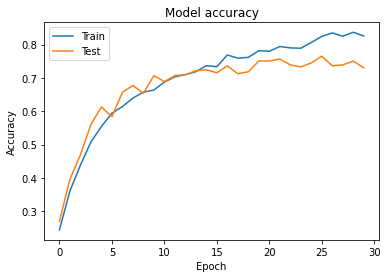

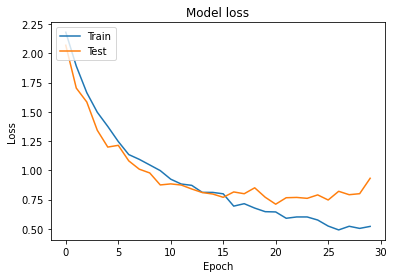

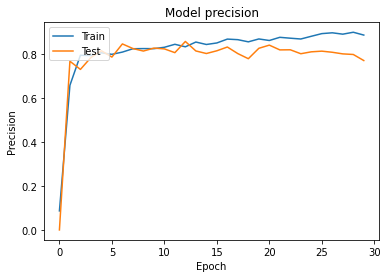

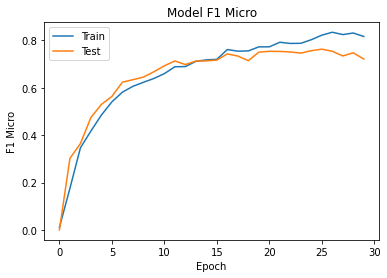

In [ ]:
# plot training history, batch_size=16, epochs=30, kernel_size=(3,3), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 / ((1/precision) + (1/recall))


np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(5,5), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(5,5), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc',f1_micro,precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=32)
# access training history
print(history.history.keys())

# Evaluate the model on the test set
print("batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)")
test_acc = model.evaluate(test_generator) 
print("Test accuracy:", test_acc[1])
print("Test f1_micro:", test_acc[2])

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/30
96/96 [==============================] - 66s 676ms/step - loss: 2.1803 - acc: 0.2383 - f1_micro: 0.0056 - precision_m: 0.0816 - recall_m: 0.0029 - val_loss: 2.1471 - val_acc: 0.2375 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
96/96 [==============================] - 64s 666ms/step - loss: 2.0261 - acc: 0.3204 - f1_micro: 0.1010 - precision_m: 0.5316 - recall_m: 0.0583 - val_loss: 1.8617 - val_acc: 0.3431 - val_f1_micro: 0.2260 - val_precision_m: 0.7052 - val_recall_m: 0.1365
Epoch 3/30
96/96 [==============================] - 62s 644ms/step - loss: 1.7269 - acc: 0.4172 - f1_micro: 0.3104 - precision_m: 0.7717 - recall_m: 0.1994 - val_loss: 1.5821 - val_acc: 0.4633 - val_f1_micro: 0.3768 - val_precision_m: 0.7398 - val_recall_m: 0.2574
Epoch 4/30
96/96 [==============================] - 62s 643ms/step

12/12 [==============================] - 2s 164ms/step - loss: 0.6323 - acc: 0.7661 - f1_micro: 0.7759 - precision_m: 0.8322 - recall_m: 0.7297
Test accuracy: 0.7661290168762207
Test f1_micro: 0.7759432792663574


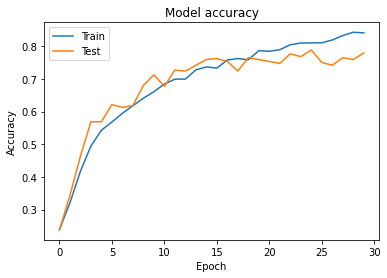

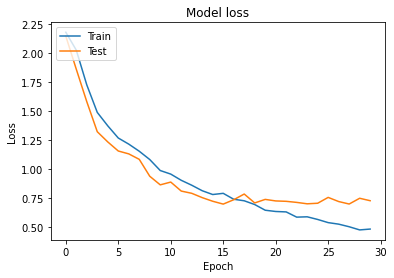

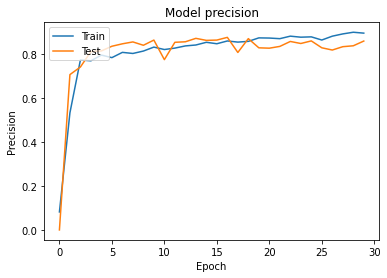

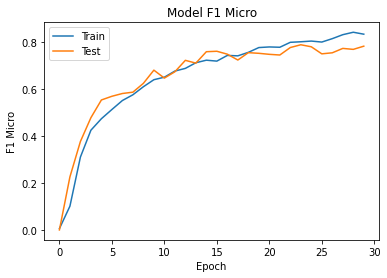

In [ ]:
# plot training history, batch_size=32, epochs=30, kernel_size=(5,5), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# batch_size=32, epochs=30, kernel_size=(7,7), pool_size=(2,2)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 / ((1/precision) + (1/recall))


np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(7,7), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(7,7), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(7,7), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=[f1_micro, precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=32)
# access training history
print(history.history.keys())

# Evaluate the model on the test set
print("batch_size=32, epochs=30, kernel_size=(7,7), pool_size=(2,2)")
test_acc = model.evaluate(test_generator) 
print("Test f1_micro:", test_acc[1])

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/30
96/96 [==============================] - 106s 1s/step - loss: 2.2138 - f1_micro: 0.0058 - precision_m: 0.0496 - recall_m: 0.0036 - val_loss: 2.1611 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
96/96 [==============================] - 98s 1s/step - loss: 2.1462 - f1_micro: 0.0044 - precision_m: 0.0677 - recall_m: 0.0023 - val_loss: 2.1537 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
96/96 [==============================] - 93s 965ms/step - loss: 2.1464 - f1_micro: 0.0016 - precision_m: 0.0125 - recall_m: 9.7656e-04 - val_loss: 2.1556 - val_f1_micro: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
96/96 [==============================] - 90s 932ms/step - loss: 2.1331 - f1_micro: 0.0013 - precision_m: 0.0208 - recall_m: 6.51

In [ ]:
# Evaluate the model on the test set
print("batch_size=32, epochs=30, kernel_size=(7,7), pool_size=(2,2)")
test_acc = model.evaluate(test_generator) 
print("Test f1_micro:", test_acc[1])

batch_size=32, epochs=30, kernel_size=(7,7), pool_size=(2,2)
12/12 [==============================] - 2s 169ms/step - loss: 0.8427 - f1_micro: 0.7375 - precision_m: 0.8239 - recall_m: 0.6687
Test f1_micro: 0.7374646663665771


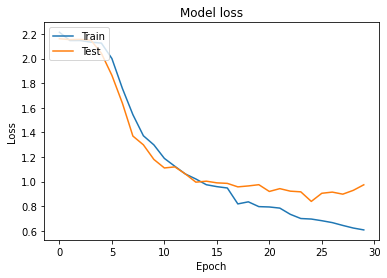

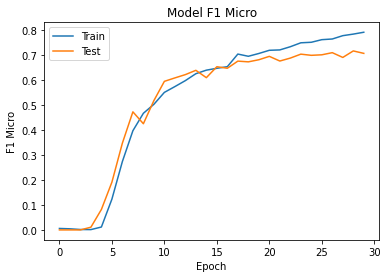

In [ ]:
# plot training history, batch_size=32, epochs=30, kernel_size=(7,7), pool_size=(2,2)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# batch_size=32, epochs=30, kernel_size=(3,3), pool_size=(3,3)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import f1_score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_micro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 / ((1/precision) + (1/recall))


np.random.seed(42)
tf.random.set_seed(42)


train_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
val_data = ImageDataGenerator(rescale=1./255) 
test_data = ImageDataGenerator(rescale=1./255) 
 
train_generator = train_data.flow_from_directory('data/clothing-dataset-small-master/train/', 
                                                    target_size=(150, 150), batch_size=32, 
                                                    class_mode='categorical') 
val_generator = val_data.flow_from_directory('data/clothing-dataset-small-master/validation', 
                                                target_size=(150, 150), batch_size=32, 
                                                class_mode='categorical') 
test_generator = test_data.flow_from_directory('data/clothing-dataset-small-master/test/', 
                                                  target_size=(150, 150), batch_size=32, 
                                                  class_mode='categorical')

#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (150,150,3)),
    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=[f1_micro, precision_m, recall_m])
history = model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=32)
# access training history
print(history.history.keys())


Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.
Epoch 1/30
58/96 [=================>............] - ETA: 10s - loss: 2.1781 - f1_micro: 0.0041 - precision_m: 0.0603 - recall_m: 0.0022

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
print("batch_size=32, epochs=30, kernel_size=(3,3), pool_size=(3,3)")
test_acc = model.evaluate(test_generator) 
print("Test f1_micro:", test_acc[1])

batch_size=32, epochs=30, kernel_size=(3,3), pool_size=(3,3)
12/12 [==============================] - 1s 91ms/step - loss: 0.8168 - f1_micro: 0.7133 - precision_m: 0.7720 - recall_m: 0.6646
Test f1_micro: 0.713293731212616


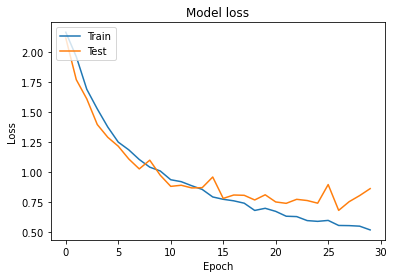

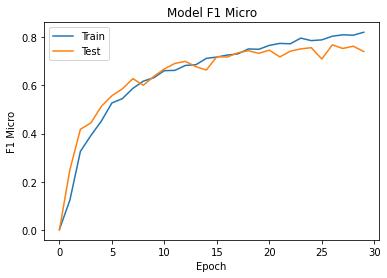

In [ ]:
# plot training history, batch_size=32, epochs=30, kernel_size=(3,3), pool_size=(3,3)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model F1 Micro')
plt.ylabel('F1 Micro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()